# ClinicalTrials.gov Dataset
## Notebook 3: Modeling

This notebook contains models for predicting a ClinicalTrials.gov record's study type (interventional or observational), based on its title.

From https://clinicaltrials.gov/ct2/about-studies/glossary: 

- **Interventional study:** A type of clinical study in which participants are assigned to groups that receive one or more intervention/treatment (or no intervention) so that researchers can evaluate the effects of the interventions on biomedical or health-related outcomes. The assignments are determined by the study's protocol. Participants may receive diagnostic, therapeutic, or other types of interventions.

- **Observational study:** A type of clinical study in which participants are identified as belonging to study groups and are assessed for biomedical or health outcomes. Participants may receive diagnostic, therapeutic, or other types of interventions, but the investigator does not assign participants to a specific interventions/treatment. A patient registry is a type of observational study.

- **Expanded access:** A way for patients with serious diseases or conditions who cannot participate in a clinical trial to gain access to a medical product that has not been approved by the U.S. Food and Drug Administration (FDA). Also called compassionate use. There are different expanded access types.

I will use logistic regression and neural networks for modeling.

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(2020)

### Reviewing the data

In [2]:
# Reading in the dataset, a CSV containing the study records
ct = pd.read_csv('data/all_records_final.csv')
ct.set_index('date', inplace = True)
ct.head()

,nct_id,title,study_type
date,,,
2017-08-28,NCT03266497,Diet Quality Among U.S.-Born and Foreign-born ...,Observational
2017-08-24,NCT03262987,Color Doppler U/S vs MSCT Venography in the Di...,Observational
2017-08-21,NCT03260543,"A 12-week, Randomized, Double-blind, Placebo-c...",Interventional
2017-08-23,NCT03263416,"Regional, Multicentric, Randomized Study Evalu...",Interventional
2017-08-28,NCT03266614,"""Recovery 4 US"" - A Photovoice-based Social Me...",Interventional


In [3]:
# Looking at the trial types in the dataset
ct['study_type'].value_counts(normalize = True)

Interventional     0.793467
Observational      0.204731
Expanded Access    0.001803
Name: study_type, dtype: float64

I will remove the Expanded Access studies since they make up only 0.1803% of the dataset.

In [4]:
df = ct[ct['study_type'] != 'Expanded Access']
df.head()

,nct_id,title,study_type
date,,,
2017-08-28,NCT03266497,Diet Quality Among U.S.-Born and Foreign-born ...,Observational
2017-08-24,NCT03262987,Color Doppler U/S vs MSCT Venography in the Di...,Observational
2017-08-21,NCT03260543,"A 12-week, Randomized, Double-blind, Placebo-c...",Interventional
2017-08-23,NCT03263416,"Regional, Multicentric, Randomized Study Evalu...",Interventional
2017-08-28,NCT03266614,"""Recovery 4 US"" - A Photovoice-based Social Me...",Interventional


In [5]:
# Making sure the expanded access study was removed
df['study_type'].value_counts()

Interventional    253069
Observational      65297
Name: study_type, dtype: int64

### Using CountVectorizer

Since ClinicalTrials.gov records do not have consistent numerical data, I will be focusing on textual data or more precisely, on words in study titles. I'm going to start by using CountVectorizer and then seeing if certain words can be used to predict if a study is either observational or interventional.

In [6]:
# Converting study types to numerical values
df['study_type'] = df['study_type'].map({'Interventional': 1, 'Observational': 0})
df.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nct_id,title,study_type
date,,,
2017-08-28,NCT03266497,Diet Quality Among U.S.-Born and Foreign-born ...,0
2017-08-24,NCT03262987,Color Doppler U/S vs MSCT Venography in the Di...,0
2017-08-21,NCT03260543,"A 12-week, Randomized, Double-blind, Placebo-c...",1
2017-08-23,NCT03263416,"Regional, Multicentric, Randomized Study Evalu...",1
2017-08-28,NCT03266614,"""Recovery 4 US"" - A Photovoice-based Social Me...",1


In [7]:
df['study_type'].value_counts()

1    253069
0     65297
Name: study_type, dtype: int64

In [8]:
# Setting up the X and y variables
X = df['title']
y = df['study_type']

In [9]:
y.value_counts(normalize = True)

1    0.7949
0    0.2051
Name: study_type, dtype: float64

Ideally, I will be able to create a model that can predict study type more accurately than 79% which is the percentage of interventional trials in the dataset.

#### Train/test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    stratify = y, 
                                                    random_state = 88)

In [11]:
# For use with predictions later on
X_test_original = X_test.copy()

#### Count vectorizer

In [12]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             max_features = 5000) 

In [13]:
cvec.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [14]:
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [15]:
# Getting a dataframe of X_train words
X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=(cvec.get_feature_names()))
X_train_df.head()

,00,000,001,002,003,004,005,007,01,02,...,zambia,zd1839,zidovudine,zinc,ziprasidone,zoledronic,zone,zoster,µg,μg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Logistic regression model

In [16]:
# Instantiating logistic regression
lr = LogisticRegression(solver = 'lbfgs', class_weight = 'auto', max_iter = 200, random_state = 88)

# Fitting logistic regression
lr.fit(X_train, y_train)

# Evaluating the model
print(f'Training Score: {lr.score(X_train, y_train)}')
print(f'Testing Score: {lr.score(X_test, y_test)}')

Training Score: 0.884770624911658
Testing Score: 0.8762603260357446


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


My model is able to predict if a study title is accurate with an accuracy score of ```0.8763```, better than 79%! This test score is quite close to the train score of ```0.8848```.

#### Generating predictions
I want to see some titles which were predicted accurately and which were predicted incorrectly.

In [17]:
# Setting up the dataframe of predictions
predictions = pd.DataFrame(X_test_original)

In [18]:
# Creating the predicted column
predictions['predicted'] = lr.predict(X_test)

In [19]:
# Creating the actual column
y_test_array = np.array(y_test)
predictions['actual'] = y_test_array
predictions.head()

,title,predicted,actual
date,,,
2014-11-10,Examining the Feasibility and Efficacy of Adve...,1,1
2005-05-26,Effects of Tumor Necrosis Factor (TNF)-Alpha A...,1,1
2005-11-22,A Randomized Phase II Study of OGX-011 in Comb...,1,1
2018-09-05,Reproducibility of Lung Ultrasound in the Diag...,0,0
2015-06-04,Randomized Clinical Trial of Subtotal Parathyr...,1,1


In [20]:
# Viewing the entire title
pd.set_option('display.max_colwidth', -1)
# Showing studies that were incorrectly predicted
predictions.loc[predictions['predicted'] != predictions['actual']].head(15)

,title,predicted,actual
date,,,
2012-01-13,Comparison of C-reactive Protein and Procalcitonin to Detect Infectious Complications After Elective Colorectal Surgery,0,1
2008-07-07,Monitoring of Fluid Status in Heart Failure Patients by Intrathoracic Impedance Measurement,0,1
2008-07-03,Predicting Weight Loss in People With Cancer: Development of a Screening Tool,0,1
2013-07-15,"Measuring Recovery in Patients Undergoing Major Abdominal, Thoracic, and Arthroplasty Surgery Using an Enhanced Recovery Program.",1,0
2008-06-02,The Impact of African American Women's Hair Care Practices and Hair Attitudes on Exercise Habits,1,0
2006-04-24,The Pre-symptomatic Familial Amyotrophic Lateral Sclerosis (Pre-fALS) Study,1,0
2009-09-01,Ambulatory Urodynamic Evaluation of Sacral Neuromodulation for Non-obstructive Urinary Retention,1,0
2007-06-04,Outcomes Following Image-Guided Therapy for Hepatic Malignancies,1,0
2012-01-03,The Role of the Novel 99mTc-NC100692 Tracer in Patients at High Risk or Known Breast Cancer,1,0


In [21]:
# Showing studies that were correctly predicted
predictions.loc[predictions['predicted'] == predictions['actual']].head(15)

,title,predicted,actual
date,,,
2014-11-10,Examining the Feasibility and Efficacy of Adventure Based Therapy as a Treatment Intevention for Depression and Anxiety.,1,1
2005-05-26,Effects of Tumor Necrosis Factor (TNF)-Alpha Antagonism in Patients With Metabolic Syndrome,1,1
2005-11-22,A Randomized Phase II Study of OGX-011 in Combination With Docetaxel and Prednisone or Docetaxel and Prednisone Alone in Patients With Metastatic Hormone Refractory Prostate Cancer,1,1
2018-09-05,Reproducibility of Lung Ultrasound in the Diagnosis of Acute Heart Failure in the Emergency Department (ED),0,0
2015-06-04,Randomized Clinical Trial of Subtotal Parathyroidectomy or Total Parathyroidectomy With Immediate Heterotopic Autograft in Chronic Renal Disease Patients Stage V Under Dialysis,1,1
2014-04-21,Online Collaborative Learning Intervention to Prevent Perinatal Depression,1,1
2019-12-10,Investigation of the Incidence of Lingual Nerve Injury and Related Factors in Patients With Difficult Intubation,0,0
2013-11-11,A Feasibility Study to Evaluate Safety and Initial Effectiveness of ExAblate Transcranial MR Guided Focused Ultrasound Treatment of Medication-Refractory OCD,1,1
2005-09-08,An Open-label Study of the Single-dose Pharmacokinetics of Olmesartan Medoxomil in Pediatric Patients With Hypertension,1,1


Judging by the above, it may be tough to determine why study titles were misclassified, aside from titles containing words such as "trial" or "phase" or "randomized." Also, study titles vary depending on the investigator's preference and writing style.

#### Confusion matrix
I will create a confusion matrix for the predictions and to also examine sensitivity and specificity.

In [22]:
# Generating predictions
preds = lr.predict(X_test)

In [23]:
# Making a confusion matrix variable
cm = confusion_matrix(y_test, preds)

In [24]:
# Listing out the true and false positives and negatives
# Adapted from https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('True Negatives:', tn)
print('False Positives:', fp)
print('False Negatives:', fn)
print('True Positives:', tp)

True Negatives: 7835
False Positives: 5225
False Negatives: 2654
True Positives: 47960


In [25]:
# Creating a confusion matrix
cm_df = pd.DataFrame(cm, columns=['predicted observational', 'predicted interventional'], 
            index=['actual observational', 'actual interventional'])
cm_df

,predicted observational,predicted interventional
actual observational,7835,5225
actual interventional,2654,47960


In [26]:
# Calculating sensitivity, the true positive rate
47960 / (47960 + 2654)

0.9475639151222982

In [27]:
# Calculating specificity, the true negative rate
7835 / (7835 + 5225)

0.5999234303215927

With sensitivity at ```0.9476```, the model is doing well at finding the true positives (interventional trials) but at ```0.5999```, not as well at finding the true negatives (observational studies).

### Neural network

Next, I will try creating a neural network to see if I can improve upon the accuracy score of ```0.8763```.

In [28]:
# Scaling is required for neual networks and a dense matrix is also needed
ss = StandardScaler(with_mean = False)
X_train_sc = ss.fit_transform(X_train).todense()
X_test_sc = ss.transform(X_test).todense()

In [29]:
# Getting the number of inputs
X_train_sc.shape

(254692, 5000)

#### Network with 1 hidden layer, 1024 units, 10 epochs, and a batch size of 512

In [30]:
# Setting a random seed for reproducibility
np.random.seed(2020)

# Instantiating the model
model = Sequential()

# Adding the hidden layer
model.add(Dense(units = 1024,
               input_shape = (5000,),  
               activation = 'relu'))  

# Adding the final layer
model.add(Dense(units = 1, activation = 'sigmoid')) 

# Compiling the model
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['acc']) 

# Fitting the model
history = model.fit(x = X_train_sc, 
          y = y_train, 
          epochs = 10, 
          batch_size = 512, 
          validation_data = (X_test_sc, y_test),
          verbose = 1)

Train on 254692 samples, validate on 63674 samples
Epoch 1/10
254692/254692 [==============================] - 36s 140us/sample - loss: 0.3452 - acc: 0.8600 - val_loss: 0.2947 - val_acc: 0.8708
Epoch 2/10
254692/254692 [==============================] - 37s 144us/sample - loss: 0.2493 - acc: 0.8939 - val_loss: 0.2979 - val_acc: 0.8711
Epoch 3/10
254692/254692 [==============================] - 42s 166us/sample - loss: 0.2079 - acc: 0.9147 - val_loss: 0.3274 - val_acc: 0.8683
Epoch 4/10
254692/254692 [==============================] - 41s 160us/sample - loss: 0.1511 - acc: 0.9411 - val_loss: 0.3848 - val_acc: 0.8658
Epoch 5/10
254692/254692 [==============================] - 43s 169us/sample - loss: 0.1006 - acc: 0.9643 - val_loss: 0.4432 - val_acc: 0.8664
Epoch 6/10
254692/254692 [==============================] - 39s 154us/sample - loss: 0.0669 - acc: 0.9788 - val_loss: 0.5304 - val_acc: 0.8640
Epoch 7/10
254692/254692 [==============================] - 39s 152us/sample - loss: 0.0491

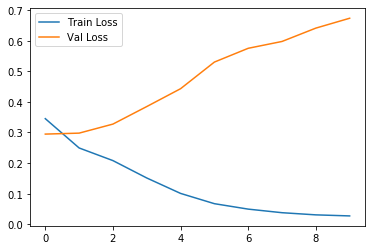

In [31]:
# Generate a line plot for loss
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.legend();

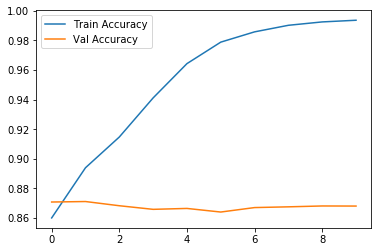

In [32]:
# Generating a line plot for accuracy
plt.plot(history.history['acc'], label = 'Train Accuracy')
plt.plot(history.history['val_acc'], label = 'Val Accuracy')
plt.legend();

There was accuracy of ```0.9936``` on the train data but ```0.8690``` on the test data which is similar to the ```0.8763``` in the logistic regression model. I will try lowering the number of epochs since accuracy was highest early in the epochs and units for the next network.

#### Network with 1 hidden layer, 18 units, 5 epochs, and a batch size of 512

In [33]:
# Setting a random seed for reproducibility
np.random.seed(2020)

# Instantiating another model
model = Sequential()

# Adding the hidden layer
model.add(Dense(units = 18,
               input_shape = (5000,),  
               activation = 'relu'))  

# Adding the final layer
model.add(Dense(units = 1, activation = 'sigmoid')) 

# Compiling the model
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['acc']) 

# Fitting the model
history = model.fit(x = X_train_sc, 
          y = y_train, 
          epochs = 5, 
          batch_size = 512, 
          validation_data = (X_test_sc, y_test),
          verbose = 1)

Train on 254692 samples, validate on 63674 samples
Epoch 1/5
254692/254692 [==============================] - 14s 56us/sample - loss: 0.3295 - acc: 0.8560 - val_loss: 0.2959 - val_acc: 0.8707
Epoch 2/5
254692/254692 [==============================] - 14s 56us/sample - loss: 0.2651 - acc: 0.8864 - val_loss: 0.2920 - val_acc: 0.8733
Epoch 3/5
254692/254692 [==============================] - 14s 56us/sample - loss: 0.2445 - acc: 0.8968 - val_loss: 0.2951 - val_acc: 0.8726
Epoch 4/5
254692/254692 [==============================] - 14s 55us/sample - loss: 0.2255 - acc: 0.9061 - val_loss: 0.3077 - val_acc: 0.8701
Epoch 5/5
254692/254692 [==============================] - 14s 54us/sample - loss: 0.2072 - acc: 0.9147 - val_loss: 0.3238 - val_acc: 0.8683


I'm still getting accuracy of ```0.8683```. I'll try adding a second layer.

#### Network with 2 hidden layers, 18 units, 5 epochs, and a batch size of 512

In [34]:
# Setting a random seed for reproducibility
np.random.seed(2020)

# Instantiating another model
model = Sequential()

# Adding the hidden layer
model.add(Dense(units = 18,
               input_shape = (5000,),  
               activation = 'relu'))  

# Adding another hidden layer
model.add(Dense(units = 32, activation = 'relu')) 

# Adding the final layer
model.add(Dense(units = 1, activation = 'sigmoid')) 

# Compiling the model
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['acc']) 

# Fitting the model
history = model.fit(x = X_train_sc, 
          y = y_train, 
          epochs = 5, 
          batch_size = 512, 
          validation_data = (X_test_sc, y_test),
          verbose = 1)

Train on 254692 samples, validate on 63674 samples
Epoch 1/5
254692/254692 [==============================] - 13s 53us/sample - loss: 0.3256 - acc: 0.8551 - val_loss: 0.2918 - val_acc: 0.8725
Epoch 2/5
254692/254692 [==============================] - 13s 52us/sample - loss: 0.2650 - acc: 0.8854 - val_loss: 0.2899 - val_acc: 0.8727
Epoch 3/5
254692/254692 [==============================] - 14s 54us/sample - loss: 0.2426 - acc: 0.8965 - val_loss: 0.2953 - val_acc: 0.8705
Epoch 4/5
254692/254692 [==============================] - 13s 52us/sample - loss: 0.2217 - acc: 0.9070 - val_loss: 0.3087 - val_acc: 0.8662
Epoch 5/5
254692/254692 [==============================] - 14s 53us/sample - loss: 0.2007 - acc: 0.9165 - val_loss: 0.3310 - val_acc: 0.8671


The accuracy with this network is ```0.8671```.

Unfortunately, the neural networks are not outperforming the logistic regression model. They are actually doing about the same. Future directions could include additional gridsearching and fine-tuning of parameters to see if a neural network might be able to have better accuracy than around 86-87%. However, these results might be expected given the nature and quantity of data.